# MODEL SETUP OG ANNOTERINGS TOOL

Goddag og velkommen, til din helt egen model der kan "finde" entiter baseret omkring "Uncertainty"


Det hele skulle være sat op så du bare kan køre cellerne fra top til bunds, du behøver kun downloade modellen 1 gang, derefter vil den selv store den på huggingface libariets directory.



### Du skal placere din fil data.json i Mappen, det er den fil du gerne vil have annoteret, se min fil som eksempel for format

## Her er requirements i nedenstående cell,

Du burde have !pip med en klassisk python installation

du kan altid tjekke om du har den med ->

python3 -m pip --version

script: til opgradering hvis nødvendigt ->

python3 -m pip install --upgrade pip

In [1]:
!pip install transformers torch


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Download Model

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# 1.
MODEL_ID = "udak4/DaBERT-UNCERTAINTY-V1" 

# Download the model
# AutoModelForTokenClassification is used for NER tasks
model = AutoModelForTokenClassification.from_pretrained(MODEL_ID)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

print(f"downloaded and loaded model: {MODEL_ID}")
print("Model is ready for use.")

config.json: 0.00B [00:00, ?B/s]

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\willi\.cache\huggingface\hub\models--Udak4--DaBERT-3Bilou-ner-trained. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
W1106 07:03:19.043000 47732 site-packages\torch\distributed\elastic\multiprocessin

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

✅ Successfully downloaded and loaded model: udak4/DaBERT-3Bilou-ner-trained
Model and Tokenizer objects are ready for use.


# Annotér med Modellen

Alt efter hvilken CPU du har, kan det tage noget tid, men det tager somregel omkring 5 minutter PS du kan justere på threshold for at lave lidt om på predictionsne, men generelt er din model ret svag, jeg fandt sweetspottet omkring 65%

In [ ]:
import json
import os
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from typing import List, Dict, Any

#config
DATA_FOR_ANNOTATION_PATH = "data.json" 
MODEL_PATH = "udak4/DaBERT-UNCERTAINTY-V1" 
OUTPUT_FILE_PATH = "model-predictions/predictions.json"
LABELSTUDIO_IMPORT_PATH = "labelstudio/import/predictions_import.json"


#Threshold for confidence filtering
CONFIDENCE_THRESHOLD = 0.65 # her kan du ændre for at se hvordan det påvirker resultaterne <<<<<<--------------------------------


def save_json_file(data: List[Dict], path: str, purpose: str):
    # output directory
    os.makedirs(os.path.dirname(path), exist_ok=True) 
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f" {purpose} saved at {path}")
    except Exception as e:
        print(f"2")

# så vi definerer vores funktion her, den tager en datapath, modelpath, outputpath og confidence threshold som hjælper med at filtrere predictions
# eftersom vi kun vil have høj confidence forudsigelser, sætter vi den på sit nuværende niveau til 0,85, du kan ændre det begge veje og justere hurtigt, da det måske giver bedre resultater
def run_inference(data_path: str, model_path: str, raw_output_path: str, ls_import_path: str, threshold: float):
    
    try:
        # Åbner og indlæser input JSON-filen
        with open(data_path, "r", encoding="utf-8") as f:
            annotation_data = json.load(f)
        print(f"loading {len(annotation_data)} lines for inference.")
    except FileNotFoundError:
        print(f" Error: file not found at '{data_path}'.")
        return
    except json.JSONDecodeError:
        print(f" Error: file not JSON at '{data_path}'.")
        return
        
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForTokenClassification.from_pretrained(model_path)
        
        # Opretter Hugging Face pipeline, som forenkler brugen af modellen til NER-opgaver og bruger GPU hvis tilgængelig
        # Vi sender objekter model, tokenizer direkte til pipeline.
        ner_pipeline = pipeline(
            "ner", 
            model=model, 
            tokenizer=tokenizer, 
            aggregation_strategy="simple", 
            device=0 if os.environ.get('CUDA_VISIBLE_DEVICES') else -1
        )

    except Exception as e:
        print(f"Error: {e}")
        return

    all_predictions = [] 
    ls_import_data = []        
    line_counter = 0
    # for alle linjer i annotation_data, tager vi text og kører NER-pipeline på den
    for item in annotation_data:
        line = item.get("text", "") 

        if not line:
            continue
            
        # Kører NER-pipeline på linjen
        ner_results = ner_pipeline(line)
        ls_results = [] # Til Label Studio result-format

        # filtrerer resultater baseret på confidence threshold
        for ent in ner_results:
            # Tjekker om modellens score opfylder det definerede threshhold
            # ja? Opretter et dictionary med prediction json klar format.
            if float(ent["score"]) >= threshold:
                ls_results.append({
                    "from_name": "label",
                    "to_name": "text",
                    "type": "labels",
                    "value": {
                        "start": int(ent["start"]),
                        "end": int(ent["end"]),
                        "text": line[int(ent["start"]):int(ent["end"])], 
                        "labels": [ent["entity_group"]],
                        "score": float(ent["score"])
                    }
                })

        # så samles resultaterne for den linjen i det endelige outputformat.
        all_predictions.append({
            "data": {
                "line_id": line_counter, 
                "text": line
            },
            "predictions": [
                {"result": ls_results}
            ]
        })
        
        # Formatér til LABEL STUDIO IMPORT
        ls_import_data.append({
            "data": {"text": line}, 
            "predictions": [{"result": ls_results}]
        })

        line_counter += 1
    
    
    # Gemmer predictions
    save_json_file(all_predictions, raw_output_path, "predictions")

    # Gemmer Label Studio importfilen
    save_json_file(ls_import_data, ls_import_path, "Label Studio Import Data")


# kører funktionen
if __name__ == "__main__":
    run_inference(
        DATA_FOR_ANNOTATION_PATH, 
        MODEL_PATH, 
        OUTPUT_FILE_PATH, 
        LABELSTUDIO_IMPORT_PATH,
        CONFIDENCE_THRESHOLD
    )

%run filter.py

loading 3594 lines for inference.


Device set to use cpu


 predictions saved at model-predictions/predictions.json
 Label Studio Import Data saved at labelstudio/import/predictions_import.json
Filter påført og outputter til: 'model-predictions/predictions.json'.
Filter påført og outputter til: 'labelstudio/import/predictions_import.json'.
   (3227 tomme objekter blev fjernet fra Label Studio importfilen.)


# (BONUS DEL) Label interface

Hvis du vil se det i label-studio interfacet, skal du kører i teminalen, til at installere interfacen:

!pip install Label-studio


Derefter kan du skrive i terminalen for at starte labelstudio

Start label-studio



# neden under er der en guide der viser hvordan du sætter dit label-studio hurtigt op

du skal forresten oprette en konto med din mail adresse for at bruge label-studio

Når du har lavet en konto, kan du bruge labelstudio, til lidt nemmere at se og holde styr på de predictions modellen har lavet.

Du kan nu bruge de respektive filer pipeline giver dig start med at oprette et label studio projekt
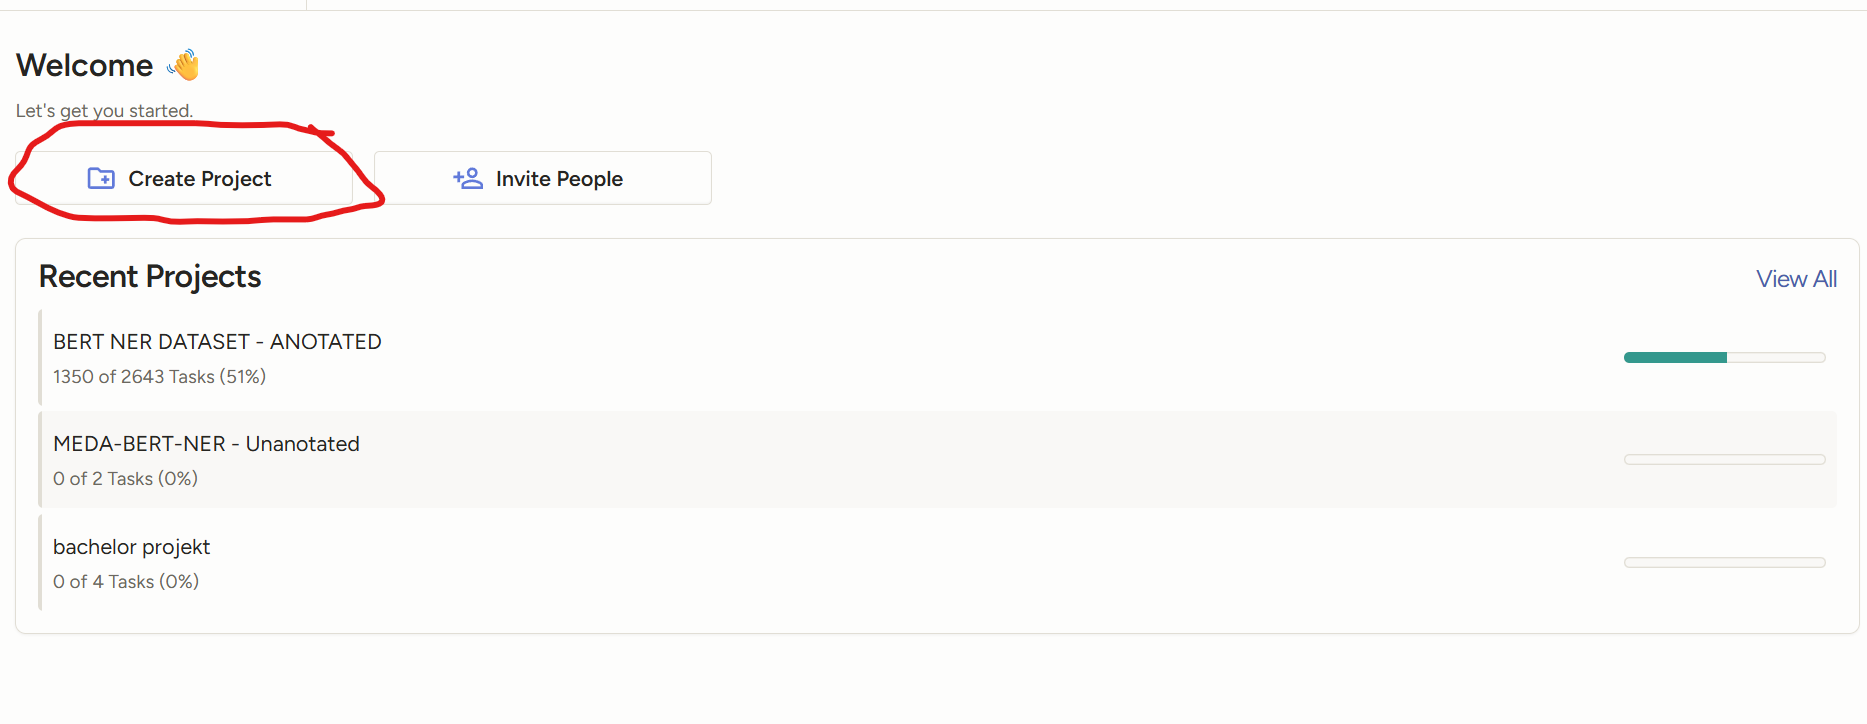

opret projektet med navn etc. og klik på labeling setup:
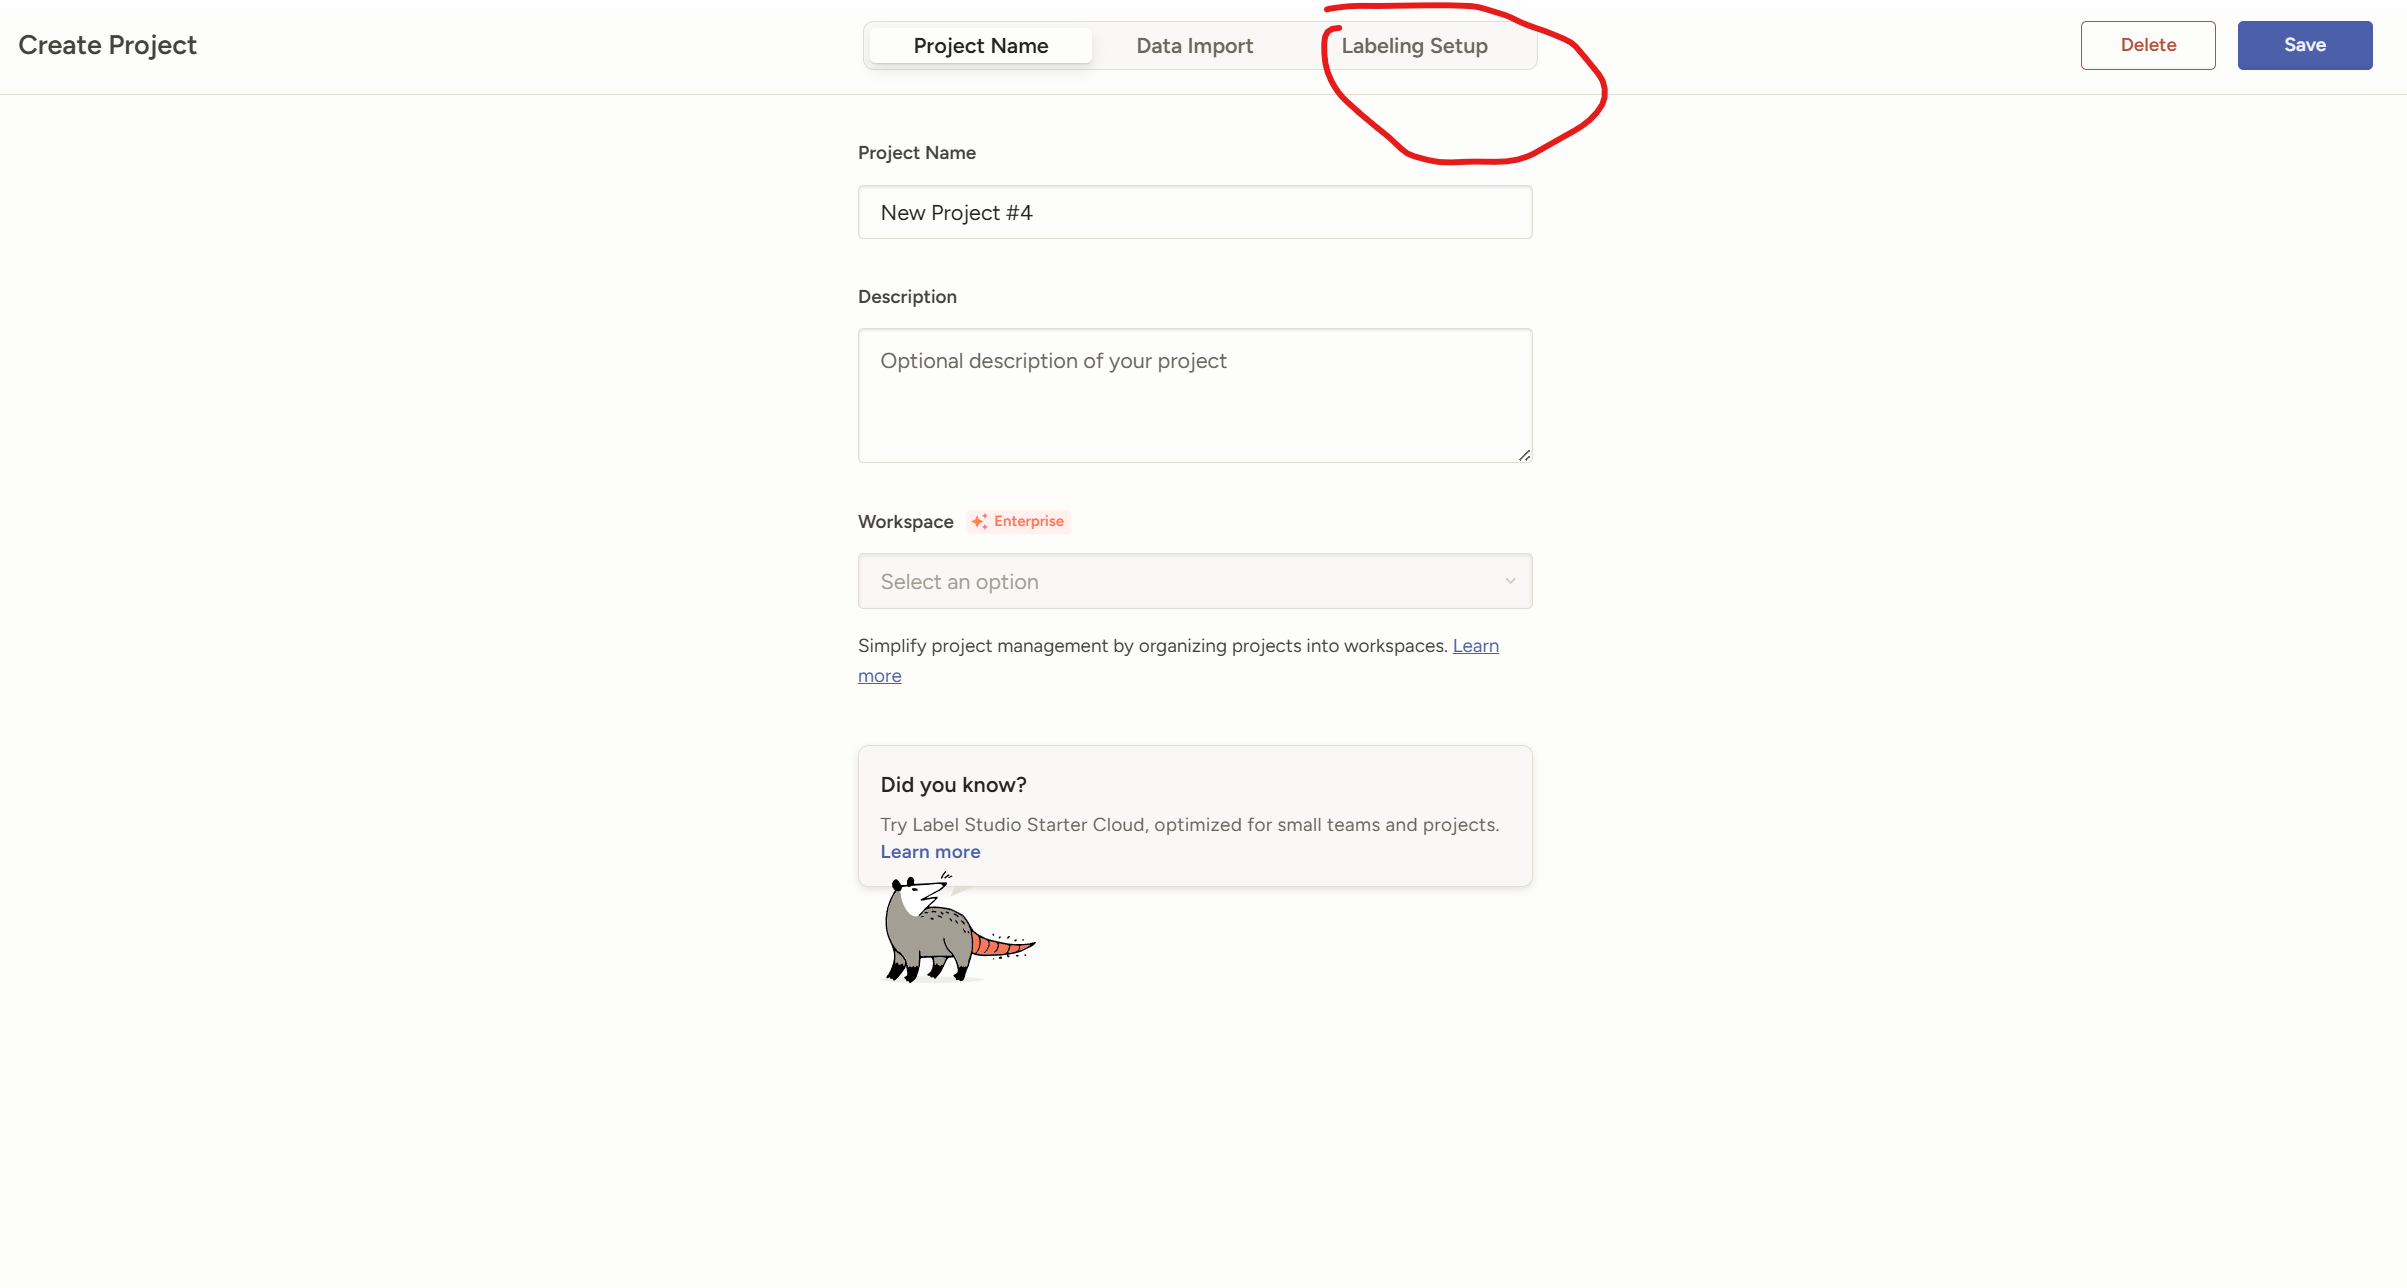

vælg custom template:
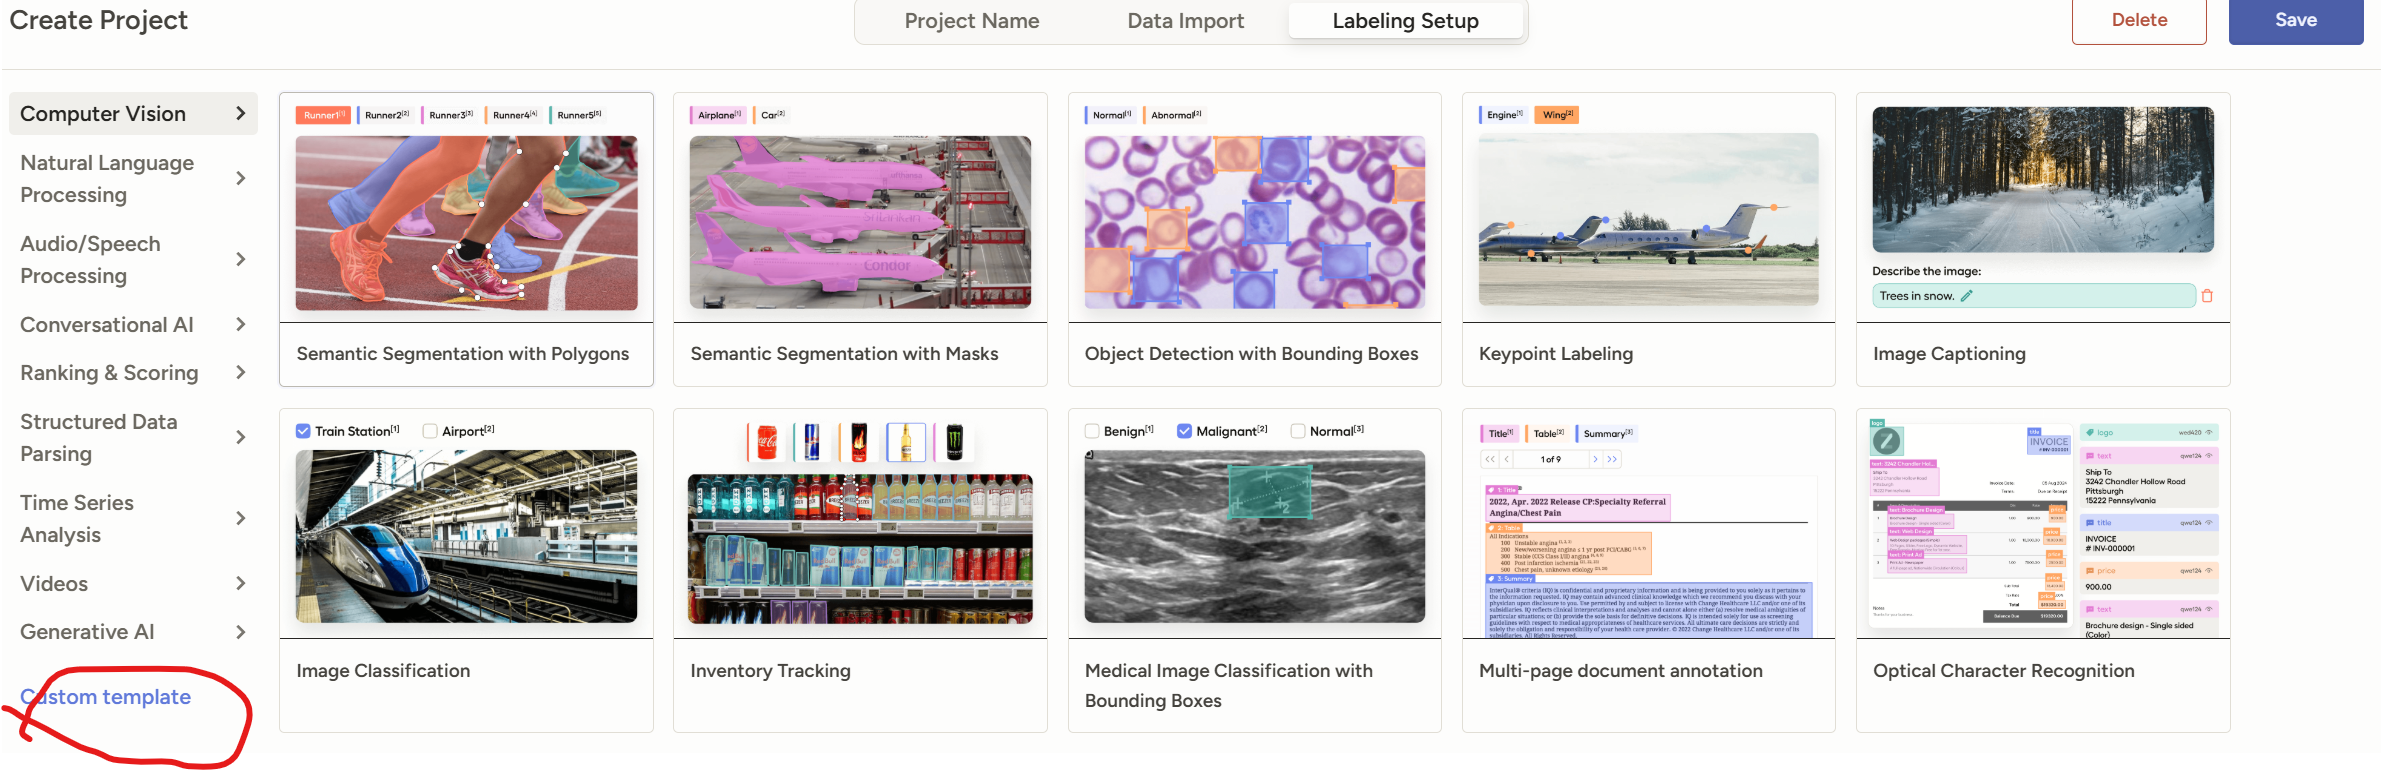

Paste config filen, som du kan finde neden under i code sectionen og tryk save
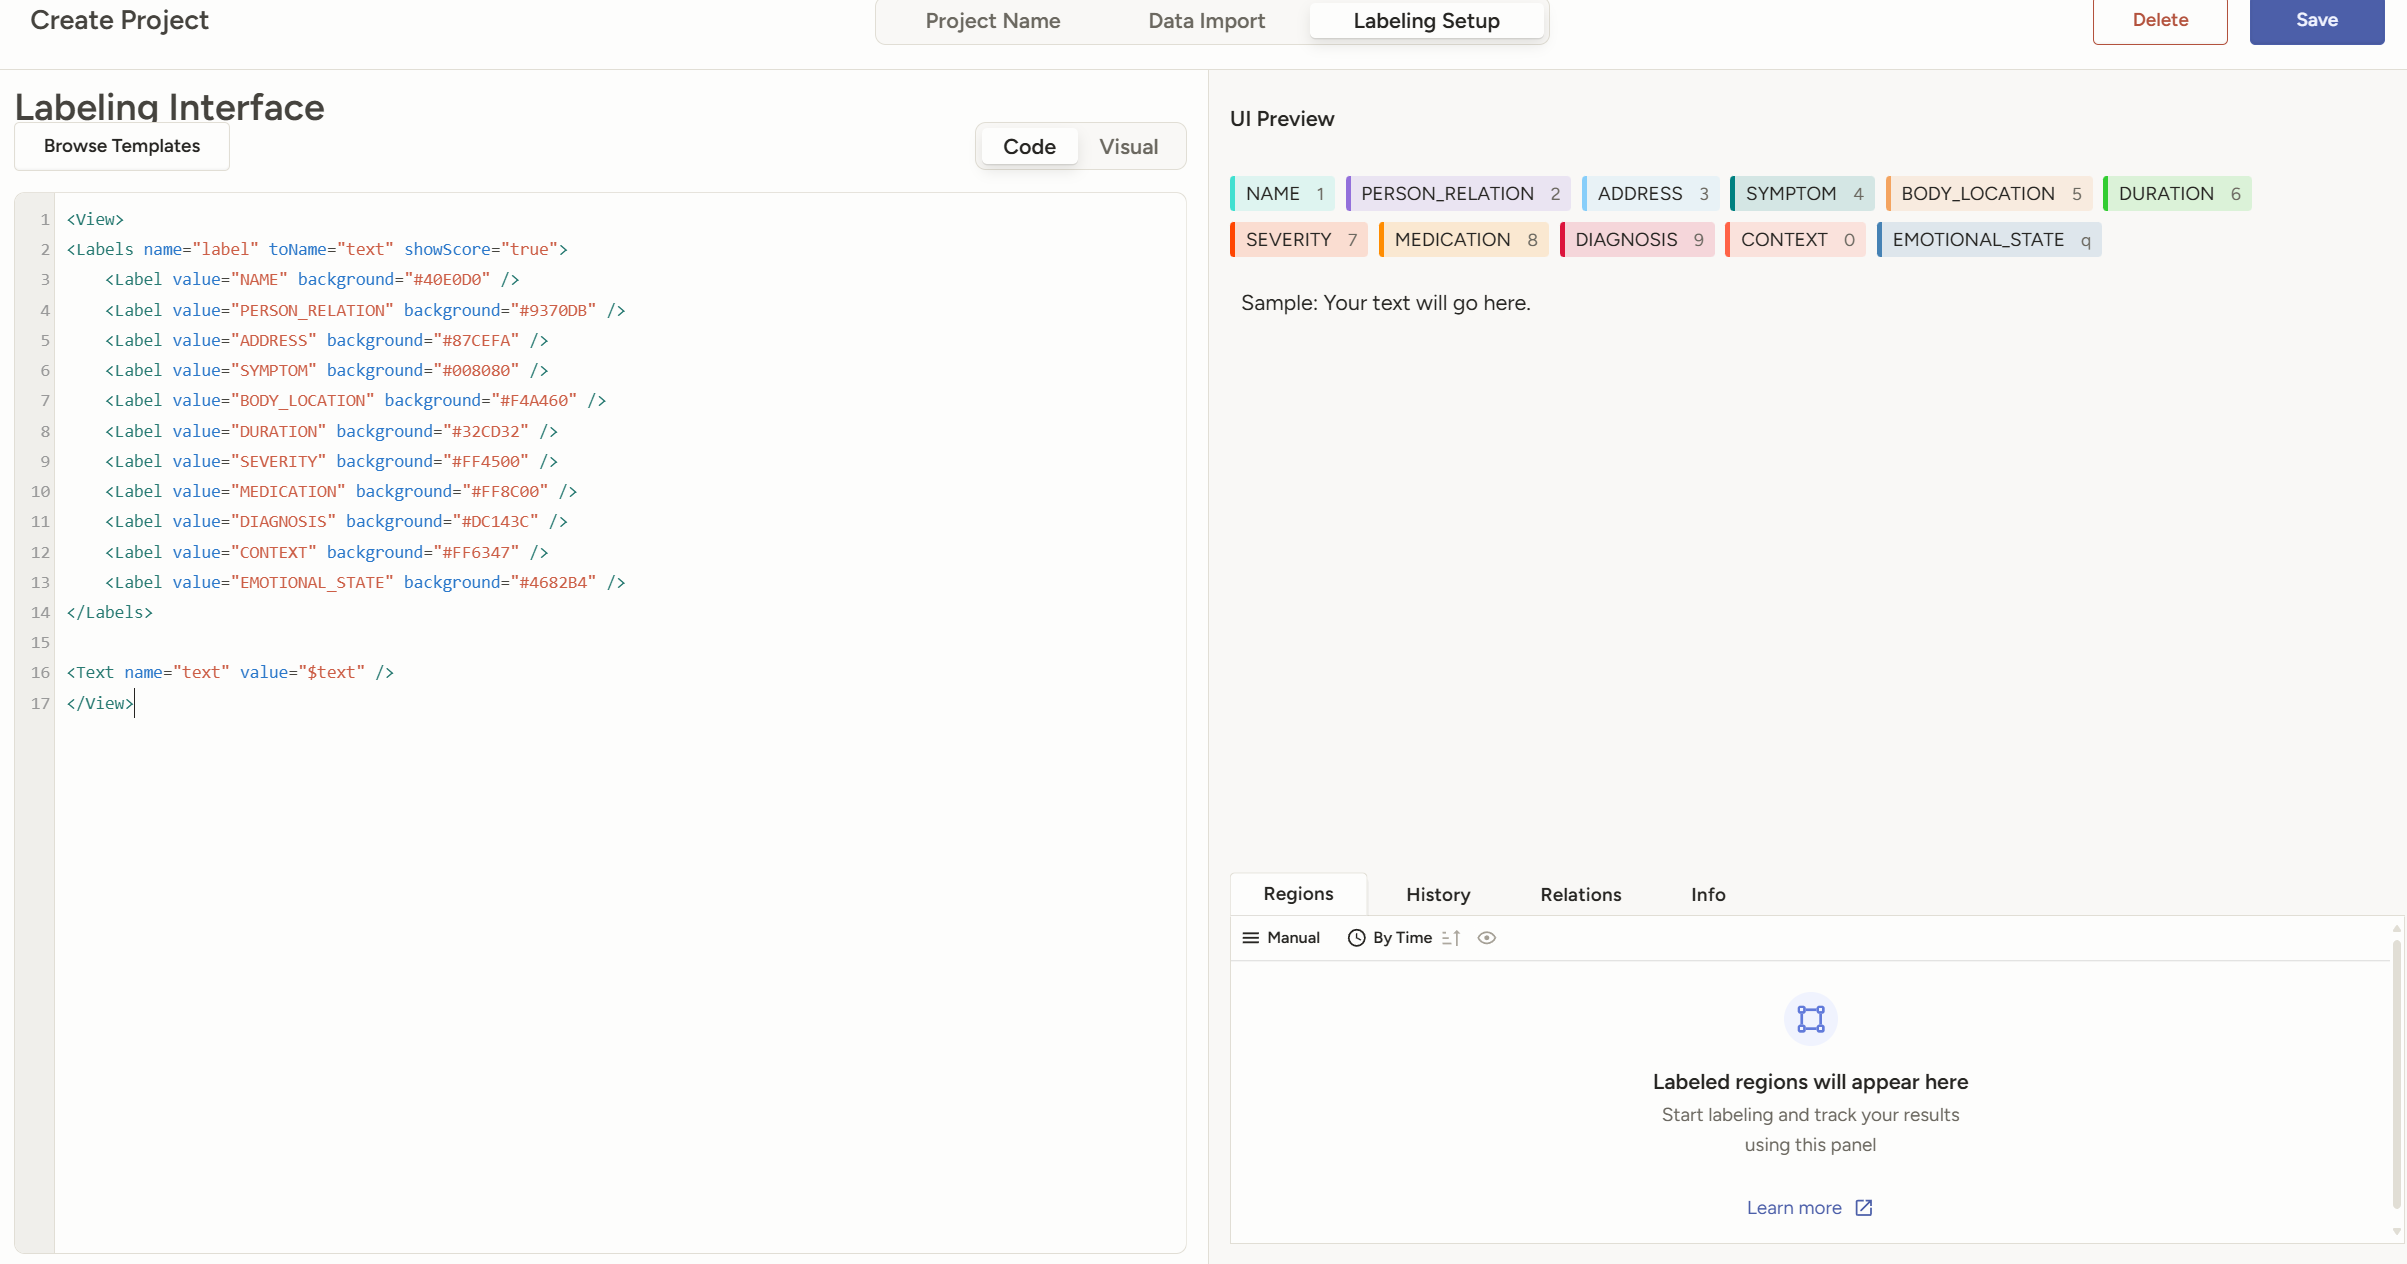

In [4]:
<View>
<Labels name="label" toName="text" showScore="true">
    <Label value="AMBIGUITY" background="#40E0D0" />
    <Label value="ALEATORIC" background="#9370DB" />
    <Label value="EMOTIONAL" background="#87CEFA" />
    <Label value="EPISTEMIC" background="#008080" />
    <Label value="CONSEQUENCE" background="#F4A460" />
</Labels>

<Text name="text" value="$text" />
</View>

SyntaxError: invalid syntax (1474684650.py, line 1)

Du kan nu ved at klikke "import", Tilføje den fil der hedder "predictions_import.json" som ligger i labelstudio-import mappen.